# Actividad: Ajuste de modelos de clasificación 

Jorge Pérez, A0102859

Diego Limón, A01638247

Josue Rodriguez, A01024035


In [65]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.utils.random import sample_without_replacement
# models
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import random


## Ejercicio 1: 

1. Carga la base de datos Iris, y grafica las observaciones incluídas en este conjunto de datos utilizando pares de variables predictoras. 

Representa la clase de cada observación con un color distinto. 



In [17]:
# Import Iris dataset
iris = datasets.load_iris()

x = iris.data[:, 2:4]    # Only take the first two features.
y = iris.target         # Get target label
targets = iris.target_names
n_targets = len(targets)
features = iris.feature_names
n_features = len(features)

# Print info
print(targets)
print(features)

# Get min and max to latter set graph limits
x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5


['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


**¿Qué representan las variables incluidas en la base de datos?**

Para saber lo que representa cada dato de la base de datos, podemos hacer uso del _target_ y _feature_ names. Este nos indica la clasificación de cada dato, así como los parámetros característicos del mismo. 

Al imprimir los valores, nos damos cuenta que existen 3 clases, y 4 features.

([], [])

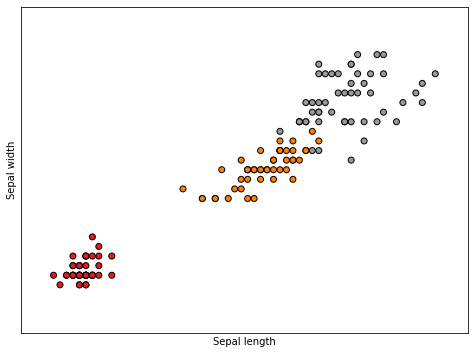

In [18]:
# Plot the training points
plt.figure(2, figsize=(8, 6))
plt.clf()

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

**¿Consideras que las variables predictoras tienen información suficiente para determinar la clase de cada uno de los tipos de datos?**

Cuando las variables predictoras se agrupan en pares, es muy complicado tener una clara separación de los datos. Con los conjuntos 1-2 y 2-3 prácticamente era imposible dividir de manera clara estas clases. Esto cambió cuando se usó el par 3-4, pues sí se nota una distinción entre clases, aún así, consideramos que es necesario darle más variables al modelo, para que logre segmentar las clases lo mejor posible.

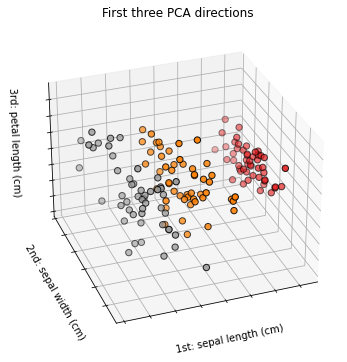

In [27]:
# To get a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st: {}".format(features[0]))
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd: {}".format(features[1]))
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd: {}".format(features[2]))
ax.w_zaxis.set_ticklabels([])

plt.show()

2. Entrena un clasificador SVM lineal con todos los datos. No olvides indicar en los parámetros del clasificador kernel ='lineal'. Inventa 10 nuevas observaciones, y verifica el resultado obtenido al evaluar el clasificador con estos nuevos datos. 

Una vez que inventamos los datos, hacemos un predict para evaular la clasificación que tendría cada uno. El vector que se regresa, es la clase de cada "punto" evaluado con el modelo, donde la clase 0 corresponde a "setosa", 1 : 'versicolor' y 2: 'virginica'.

In [29]:
# Update x to include all labels
x = iris.data

clf = svm.SVC(kernel = 'linear')
clf.fit(x, y)

newEvals = [[ 1.0, 2.5, 3.1, 5.6],
            [ 1.6, 3.3, 1.1, 8.9],
            [ 3.5, 6.9, 0.8, 3.5],
            [ 2.6, 4.1, 8.1, 6.4],
            [ 8.3, 0.2, 2.7, 1.2],
            [ 4.1, 5.0, 6.7, 6.1],
            [ 0.8, 6.2, 4.7, 0.3],
            [ 1.6, 8.4, 6.3, 1.5],
            [ 4.3, 0.5, 1.9, 2.0],
            [ 6.3, 1.8, 4.8, 7.9]]

print("==== Invented evaluation results: ====")
print(clf.predict(newEvals))


==== Invented evaluation results: ====
[2 2 0 2 1 2 1 1 1 2]


3. Evalúa el modelo de clasificación con k-fold cross validation (k = 10). Calcula la exactitud del clasificador (accuaracy), así como la precisión y el recall para cada clase. Puedes utilizar para este punto la matriz de confusión calculada con sklearn.

_Recordemos:_ StratifiedKFold, es una función que nos permite dividir nuestro dataset en n_splits de manera aleatoria. Esto se relaciona con el _cross validation_, porque cuando tenemos una pequeña cantidad de datos, y entrenamos un modelo, no tenemos una "buena" manera de corroborar cómo es que este modelo se comportará con datos externos. 
El kFold, en conjunto con cross validation nos dará un estimado de esto, entrenando diferentes veces un mismo modelo, pero con el dataset segmentado.

Esto lo podemos hacer de manera "manual", como se muestra en la primera celda de código, utilizando la función de *cross_validate*. Como se observa, se tienen resultados muy similares.

In [35]:
# Crear modelo Kfold
splits = 10
kf = StratifiedKFold(n_splits = splits, shuffle = True)

# Initialize variables
acc = 0
recall = np.array([0., 0., 0.])
precision = np.array([0., 0., 0.])

# Iterar sobre todas las segmentaciones del KFold
for train_index, test_index in kf.split(x, y):
    
    # Training phase
    x_train = X_reduced[train_index, :]
    y_train = y[train_index]

    clf_cv = svm.SVC(kernel = 'linear')
    clf_cv.fit(x_train, y_train)

    # Test phase
    x_test = X_reduced[test_index, :]
    y_test = y[test_index]    
    y_pred = clf_cv.predict(x_test)

    # Calculate confusion matrix and model performance
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n', cm)
    
    acc += (cm[0,0]+cm[1,1]+cm[2,2])/len(y_test)    

    recall[0] += cm[0,0]/(cm[0,0] + cm[0,1] + cm[0,2])
    recall[1] += cm[1,1]/(cm[1,0] + cm[1,1] + cm[1,2])
    recall[2] += cm[2,2]/(cm[2,0] + cm[2,1] + cm[2,2])

    precision[0] += cm[0,0]/(cm[0,0] + cm[1,0] + cm[2,0])
    precision[1] += cm[1,1]/(cm[0,1] + cm[1,1] + cm[2,1])
    precision[2] += cm[2,2]/(cm[0,2] + cm[1,2] + cm[2,2])

# Print results
acc = acc/splits
print('Acc: ', acc)

precision = precision/splits
print('Precision: ', precision)

recall = recall/splits
print('Recall: ', recall)


Confusion matrix
 [[5 0 0]
 [0 5 0]
 [0 0 5]]
Confusion matrix
 [[5 0 0]
 [0 5 0]
 [0 1 4]]
Confusion matrix
 [[5 0 0]
 [0 5 0]
 [0 0 5]]
Confusion matrix
 [[5 0 0]
 [0 5 0]
 [0 0 5]]
Confusion matrix
 [[5 0 0]
 [0 5 0]
 [0 0 5]]
Confusion matrix
 [[5 0 0]
 [0 3 2]
 [0 0 5]]
Confusion matrix
 [[5 0 0]
 [0 5 0]
 [0 0 5]]
Confusion matrix
 [[5 0 0]
 [0 5 0]
 [0 0 5]]
Confusion matrix
 [[5 0 0]
 [0 5 0]
 [0 0 5]]
Confusion matrix
 [[5 0 0]
 [0 4 1]
 [0 0 5]]
Acc:  0.9733333333333334
Precision:  [1.         0.98333333 0.9547619 ]
Recall:  [1.   0.94 0.98]


In [36]:
# 10 - fold cross-validation using cross_validate
clf_cv = svm.SVC(kernel = 'linear')
cv_results = cross_validate(clf_cv, X_reduced, y, cv = splits, scoring = ('accuracy', 'recall_micro'))
print('Acc: ', cv_results['test_accuracy'].sum()/splits)
print('Recall: ', cv_results['test_recall_micro'].sum()/splits)

Acc:  0.9800000000000001
Recall:  0.9800000000000001


## Ejercicio 2: 

Carga la base de datos Wine y muestra las variables predictoras de este conjunto de datos.

1. ¿Cuántas variables y observaciones por clase hay en este conjunto de datos? 
2. ¿Qué representan los predictores?

In [33]:
# Import Iris dataset
wineDataset = datasets.load_wine()

featureValues_wine = wineDataset.data     # Take the all features.
labels_wine = wineDataset.target         # Get target labels
   
# Print info
print("Features: ", len(wineDataset.feature_names))
print(wineDataset.feature_names)

print("===================")
print("Classes: ", len(wineDataset.target_names))
print(wineDataset.target_names)

print("===================")


# Get min and max to latter set graph limits
x_min, x_max = featureValues_wine[:, 0].min() - 0.5, featureValues_wine[:, 0].max() + 0.5
y_min, y_max = featureValues_wine[:, 1].min() - 0.5, featureValues_wine[:, 1].max() + 0.5

Features:  13
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Classes:  3
['class_0' 'class_1' 'class_2']



**Calcula la exactitud de los siguientes modelos de clasificación con k-fold cross validation (k = 5) para la base de datos Wine:**
* SVM lineal (kernel ='lineal')
* SVM de base radial (kernel ='rbf')
* k-NN (para k = 3)
* Árbol de decisión
* Cualquier otro clasificador que esté implementado en sklearn

In [43]:
# Cross validation splits:
splits = 5

print("==== RBF ====")
clf_cv = svm.SVC(kernel = 'rbf')
cv_results = cross_validate(clf_cv, featureValues_wine, labels_wine, cv = splits, scoring = ('accuracy', 'recall_micro'))
print('Acc: ', np.mean(cv_results['test_accuracy']))
print('Recall: ', np.mean(cv_results['test_recall_micro']))

print("==== Linear ====")
clf_cv = svm.SVC(kernel = 'linear')
cv_results = cross_validate(clf_cv, featureValues_wine, labels_wine, cv = splits, scoring = ('accuracy', 'recall_micro'))
print('Acc: ', np.mean(cv_results['test_accuracy']))
print('Recall: ', np.mean(cv_results['test_recall_micro']))

print("==== Sigmoid ====")
clf_cv = svm.SVC(kernel = 'sigmoid')
cv_results = cross_validate(clf_cv, featureValues_wine, labels_wine, cv = splits, scoring = ('accuracy', 'recall_micro'))
print('Acc: ', np.mean(cv_results['test_accuracy']))
print('Recall: ', np.mean(cv_results['test_recall_micro']))

print("==== K-NN ====")
clf_cv = KNeighborsClassifier(n_neighbors = 3)
cv_results = cross_validate(clf_cv, featureValues_wine, labels_wine, cv = splits, scoring = ('accuracy', 'recall_micro'))
print('Acc: ', np.mean(cv_results['test_accuracy']))
print('Recall: ', np.mean(cv_results['test_recall_micro']))

print("==== Decision tree ====")
clf_cv = DecisionTreeClassifier(random_state = 0)
cv_results = cross_validate(clf_cv, featureValues_wine, labels_wine, cv = splits, scoring = ('accuracy', 'recall_micro'))
print('Acc: ', np.mean(cv_results['test_accuracy']))
print('Recall: ', np.mean(cv_results['test_recall_micro']))



==== RBF ====
Acc:  0.6634920634920635
Recall:  0.6634920634920635
==== Linear ====
Acc:  0.961111111111111
Recall:  0.961111111111111
==== Sigmoid ====
Acc:  0.1638095238095238
Recall:  0.1638095238095238
==== K-NN ====
Acc:  0.7028571428571428
Recall:  0.7028571428571428
==== Desition tree ====
Acc:  0.8876190476190475
Recall:  0.8876190476190475


3. Indica con qué clasificador se obtuvieron los mejores resultados.

Para el dataset anterior, el mejor clasificador, fue el linear, con un accuracy del 96%, seguido por el decision tree, con una de 88%

## Ejercicio 3: 


1. Con el conjunto datos misterious_data_1 con dos clases, calcula la exactitud de un clasificador SVM lineal con k-fold cross validation (k = 5). En este archivo, la primera columna corresponde a la etiqueta o clase (1 o 2), y el resto de las columnas son variables o predictores.

*Como recomendación del profesor, siempre que las clases sean binarias, debemos de cambiar la clasificación a -1 y 1, es por esto que modificamos el archivo de *misterious_data_1*


In [82]:
data3 = np.loadtxt("./data/misterious_data_1.txt")

# Extract features
x_3 = data3[:,1:]
# Extract labels
y_3 = data3[:,0]

# Print info
print("Features: ", len(x_3[0]))
print("===================")
print("Classes: ", len(set(y_3)))
print("===================")

splits = 5

print("==== Linear ====")
clf_cv = svm.SVC(kernel = 'linear')
cv_results = cross_validate(clf_cv, x_3, y_3, cv = splits, scoring = ('accuracy', 'recall_micro'))
print('Acc: ', np.mean(cv_results['test_accuracy']))
print('Recall: ', np.mean(cv_results['test_recall_micro']))


Features:  153
Classes:  2
==== Linear ====
Acc:  0.7821743036837376
Recall:  0.7821743036837376


2. Selecciona aleatoriamente el 10% de todas las observaciones de la base de datos misteriosos, y repite la evaluación del clasificador con k-fold cross validation pero con los datos seleccionados.

In [75]:
print("Total samples:", len(x_3))

# Calculate # samples
desiredPercent = 10
percentage = round(len(x_3)/100 * desiredPercent)

print("There'll be ", percentage, "samples from the original data")

x_3SampledIdx = random.choices(list(range(len(x_3))), k = percentage)

# Fill data with random indexes
    # TODO: find a better way
x_3Sampled = []
y_3Sampled = []

for i in x_3SampledIdx:
    x_3Sampled.append(x_3[i])
    y_3Sampled.append(y_3[i])

print("==== Linear ====")
clf_cv = svm.SVC(kernel = 'linear')
cv_results = cross_validate(clf_cv, x_3Sampled, y_3Sampled, cv = 5, scoring = ('accuracy', 'recall_micro'))
print('Acc: ', np.mean(cv_results['test_accuracy']))
print('Recall: ', np.mean(cv_results['test_recall_micro']))

Total samples: 528
There'll be  53 samples from the original data
==== Linear ====
Acc:  0.6818181818181819
Recall:  0.6818181818181819



3. Repite el paso anterior, pero con 15%, 20%, 25%, 30%, 35%, 40%, ..., 95% de los datos. 
4. De acuerdo a los resultados del apartado anterior, ¿cuántas observaciones creen que son necesarias para entrenar el modelo para el tipo de datos probados?

De acuerdo a los resultados, cerca del 50% de los datos, el accuracy del sistema se mantiene muy similar, por lo que no vería muchas ventajas de darle un mayor número de registros a los datos de entrenamiento. Aún así, es importante, que el muestreo aleatorio, se realice de manera proporcional a los datos totales, ya que al ser totalmente aleaotrio, puede darse el caso de que el sistema esté sesgado a una clase. Esto sucede con el método que escogimos para obtener los datos.


==== Accuracy over # samples ====
[0.7890909090909091, 0.7341666666666666, 0.7086580086580087, 0.7119658119658119, 0.7657258064516129, 0.8216216216216216, 0.810077519379845, 0.8111702127659575, 0.8560232220609578, 0.8379310344827587, 0.8140873015873016, 0.8047314578005116, 0.8405405405405407, 0.8686392405063291, 0.826890756302521, 0.8797003745318351, 0.8378947368421052, 0.8664752475247525]


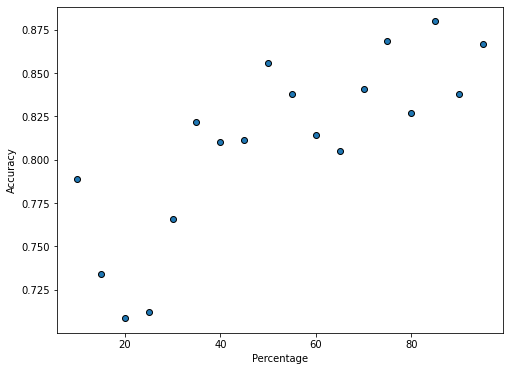

In [80]:
accHistorical = []

for desiredPercent in range(10, 96, 5):
    percentage = round(len(x_3)/100 * desiredPercent)

    x_3SampledIdx = random.choices(list(range(len(x_3))), k = percentage)

    # Fill data with random indexes
        # TODO: find a better way
    x_3Sampled = []
    y_3Sampled = []

    for i in x_3SampledIdx:
        x_3Sampled.append(x_3[i])
        y_3Sampled.append(y_3[i])

    clf_cv = svm.SVC(kernel = 'linear')
    cv_results = cross_validate(clf_cv, x_3Sampled, y_3Sampled, cv = 5, scoring = ('accuracy', 'recall_micro'))
    accHistorical.append(np.mean(cv_results['test_accuracy']))

print("==== Accuracy over # samples ====")
# Graph
# Plot the training points
plt.figure(4, figsize=(8, 6))
plt.clf()

plt.scatter(range(10, 96, 5), accHistorical,cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Percentage")
plt.ylabel("Accuracy")
print(accHistorical)

## Ejercicio 4:

1. Con el conjunto de datos misteriosos *misterious_data_2* con tres clases, calcula la exactitud de un clasificador k-NN con k-fold cross validation (5 pliegues), para k = 1, 2, 3, 4, ..., 40 del clasificador. De acuerdo a los resultados del apartado anterior, ¿qué valor de k es el óptimo para los datos probados? En este archivo, la primera columna corresponde a la etiqueta o clase (1, 2 o 3), y el resto de las columnas son variables o predictores.

Por lo que se observa en la gráfica, el K optimo se encuentra cercano a 20, creo que no sería correcto usar el valor máximo, ya que podríamos estar haciendo un overfit del modelo. 

Features:  324
Classes:  3
==== Accuracy over # samples ====
The max is:  20


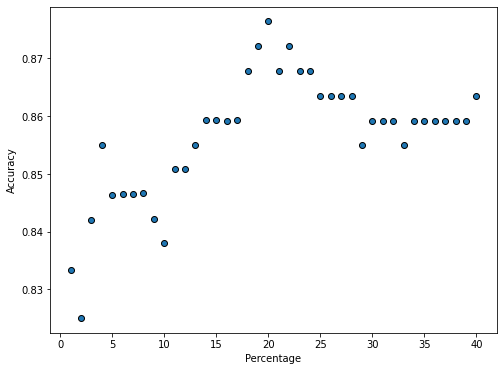

In [87]:
data4 = np.loadtxt("./data/misterious_data_2.txt")

# Extract features
x_4 = data4[:,1:]
# Extract labels
y_4 = data4[:,0]

# Print info
print("Features: ", len(x_4[0]))
print("===================")
print("Classes: ", len(set(y_4)))
print("===================")

# Clean array 
accHistorical = []

for k in range(1, 41):
    clf_cv = KNeighborsClassifier(n_neighbors = k)
    cv_results = cross_validate(clf_cv, x_4, y_4, cv = 5, scoring = ('accuracy', 'recall_micro'))
    accHistorical.append(np.mean(cv_results['test_accuracy']))

print("==== Accuracy over k value ====")
# Graph
# Plot the training points
plt.figure(5, figsize=(8, 6))
plt.clf()

plt.scatter(range(1, 41), accHistorical, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Percentage")
plt.ylabel("Accuracy")
print("The max is: ", list(range(1, 41))[ accHistorical.index(max(accHistorical))])


2. Con la misma base de datos, calcula la exactitud de un clasificador SVM lineal para diferentes valores del factor de regularización C = 0.000001, 0.000002, 0.000003, 0.000004, 0.000005, 0.000006, 0.000007, ..., 0.0001. De acuerdo a los resultados del apartado anterior, ¿qué valor de este parámetro es el óptimo?

Desde mi punto de vista, el valor óptimo es cercano a 0.00004, ya que el retorno en accuracy incrementado se incrementa poco a partir de este punto.
Algo que no me quedó claro, fue si el valor C (parámetro de regularización), afecta el tiempo de ejecución de entrenamiento del modelo, porque, en caso de que no, podríamos escoger un valor de C que nos dé mayor accuracy

==== Accuracy over # samples ====
The max is:  9.499999999999983e-05


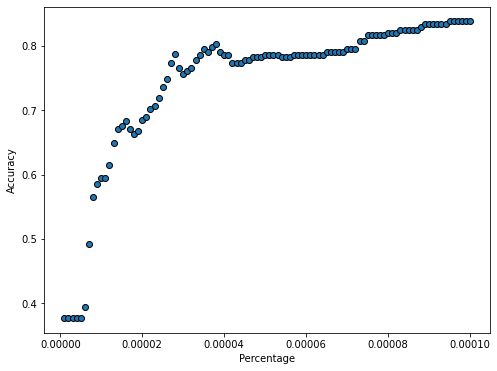

In [90]:
# Clean array 
accHistorical = []
cHistorical = []

c_val = 0.000001
while c_val <= 0.0001:
    clf_cv = svm.SVC(kernel = 'linear', C= c_val)
    cv_results = cross_validate(clf_cv, x_4, y_4, cv = 5, scoring = ('accuracy', 'recall_micro'))
    
    accHistorical.append(np.mean(cv_results['test_accuracy']))
    cHistorical.append(c_val)
    
    c_val += 0.000001

print("==== Accuracy over C value ====")
# Graph
# Plot the training points
plt.figure(6, figsize=(8, 6))
plt.clf()

plt.scatter(cHistorical, accHistorical, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Percentage")
plt.ylabel("Accuracy")
print("The max is: ", list(cHistorical)[ accHistorical.index(max(accHistorical))])

3. Con la misma base de datos, calcula la exactitud de un clasificador SVM de base radial para diferentes valores del parámetro del kernel gamma = 0.000001. 0.000002. 0.000003. 0.000004. 0.000005. 0.000006, ..., 0.0002. De acuerdo a los resultados del apartado anterior, ¿qué valor seleccionarías para este parámetro?

Escogeríamos el valor de 0.00005

==== Accuracy over Gamma value ====
The max is:  0.0001849999999999996


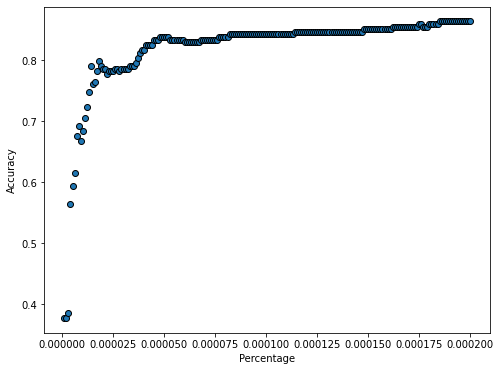

In [91]:
# Clean array 
accHistorical = []
gammaHistorical = []

gamma_val = 0.000001
while gamma_val <= 0.0002:
    clf_cv = svm.SVC(kernel = 'rbf', gamma= gamma_val)
    cv_results = cross_validate(clf_cv, x_4, y_4, cv = 5, scoring = ('accuracy', 'recall_micro'))
    
    accHistorical.append(np.mean(cv_results['test_accuracy']))
    gammaHistorical.append(gamma_val)
    
    gamma_val += 0.000001

print("==== Accuracy over Gamma value ====")
# Graph
# Plot the training points
plt.figure(7, figsize=(8, 6))
plt.clf()

plt.scatter(gammaHistorical, accHistorical, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Percentage")
plt.ylabel("Accuracy")
print("The max is: ", list(gammaHistorical)[ accHistorical.index(max(accHistorical))])